In [12]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from tools.model_builder import make_mcd_model, make_mlp_model, make_vi_model
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import get_breslow_survival_times, compute_survival_times

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

MLP_RUNS = 1
VI_RUNS = 100
MCD_RUNS = 100

# Load config
config = load_config(pt.MLP_CONFIGS_DIR, f"SEER.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
custom_objects = {"CoxPHLoss": CoxPHLoss()}
with tf.keras.utils.custom_object_scope(custom_objects):
    loss_fn = tf.keras.losses.deserialize(config['loss_fn'])
activation_fn = config['activiation_fn']
layers = config['network_layers']
dropout_rate = config['dropout_rate']
l2_reg = config['l2_reg']
batch_size = config['batch_size']

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Create model instances
mlp_model = make_mlp_model(input_shape=X_train.shape[1:], output_dim=1,
                           layers=layers, activation_fn=activation_fn,
                           dropout_rate=dropout_rate, regularization_pen=l2_reg)
vi_model = make_vi_model(n_train_samples=X_train.shape[0],
                         input_shape=X_train.shape[1:], output_dim=2,
                         layers=layers, activation_fn=activation_fn,
                         dropout_rate=dropout_rate, regularization_pen=l2_reg)
mcd_model = make_mcd_model(input_shape=X_train.shape[1:], output_dim=2,
                       layers=layers, activation_fn=activation_fn,
                       dropout_rate=dropout_rate, regularization_pen=l2_reg)

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
mlp_model.load_weights(f'{root_dir}/models/seer_mlp')
vi_model.load_weights(f'{root_dir}/models/seer_vi')
mcd_model.load_weights(f'{root_dir}/models/seer_mcd')

optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95, weight_decay=0.95)
loss_fn = CoxPHLoss()
mlp_model.compile(loss=loss_fn, optimizer=optimizer)
vi_model.compile(loss=loss_fn, optimizer=optimizer)
mcd_model.compile(loss=loss_fn, optimizer=optimizer)

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


In [13]:
# Train the Brewslow estimator for MLP and make surv funcs
event_times = range(107)
mlp_breslow_surv_times = get_breslow_survival_times(mlp_model, X_train, X_test, e_train, t_train, MLP_RUNS)
vi_breslow_surv_times = get_breslow_survival_times(vi_model, X_train, X_test, e_train, t_train, VI_RUNS)
mcd_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test, e_train, t_train, MCD_RUNS)

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


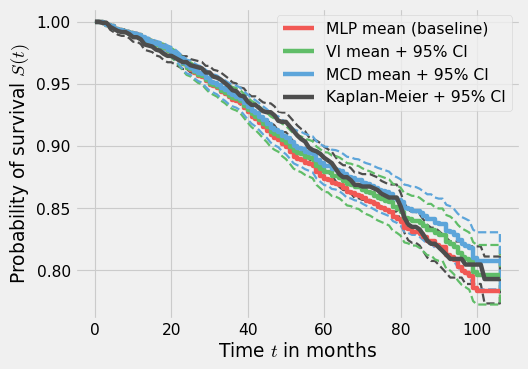

In [14]:
# Estimate CI and mean survival time
mlp_ci_surv = 1.96 * np.mean(np.std(mlp_breslow_surv_times, axis=1) / np.sqrt(MLP_RUNS), axis=0) # 95% CI
mlp_mean_surv_times = np.mean(np.mean(mlp_breslow_surv_times, axis=1), axis=0)

vi_ci_surv = 1.96 * np.mean(np.std(vi_breslow_surv_times, axis=1) / np.sqrt(VI_RUNS), axis=0) # 95% CI
vi_mean_surv_times = np.mean(np.mean(vi_breslow_surv_times, axis=1), axis=0)

mcd_ci_surv = 1.96 * np.mean(np.std(mcd_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
mcd_mean_surv_times = np.mean(np.mean(mcd_breslow_surv_times, axis=1), axis=0)

# KM
km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['time'].reshape(1,-1),
                                                       y_test['event'].reshape(1,-1),
                                                       event_times)

# Plot surv funcs with mean and CI
plt.figure(dpi=80)
plt.step(event_times, mlp_mean_surv_times, where="post", label="MLP mean (baseline)", color=TFColor[0])
plt.step(event_times, vi_mean_surv_times, where="post", label="VI mean + 95% CI", color=TFColor[2])
plt.step(event_times, mcd_mean_surv_times, where="post", label="MCD mean + 95% CI", color=TFColor[3])
plt.plot(km_mean.columns, km_mean.iloc[0], 'k-', label="Kaplan-Meier + 95% CI", color=TFColor[8])
plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], color="none", edgecolor=TFColor[8], linewidth=2, ls="--")
plt.fill_between(event_times, vi_mean_surv_times-vi_ci_surv, vi_mean_surv_times+vi_ci_surv, color="none", edgecolor=TFColor[2], linewidth=2, ls="--")
plt.fill_between(event_times, mcd_mean_surv_times-mcd_ci_surv, mcd_mean_surv_times+mcd_ci_surv, color="none", edgecolor=TFColor[3], linewidth=2, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ in months")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_all_models.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

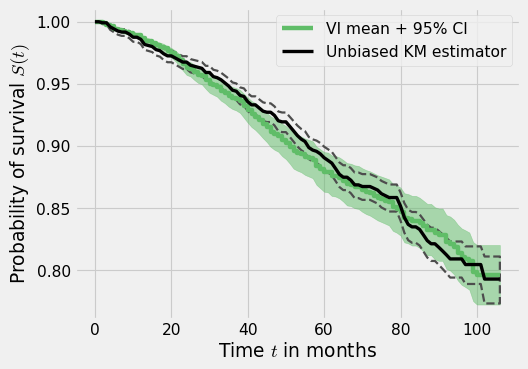

In [15]:
plt.figure(dpi=80)
plt.step(event_times, vi_mean_surv_times, where="post", label="VI mean + 95% CI", color=TFColor[2])
plt.plot(km_mean.columns, km_mean.iloc[0], 'k-', label='Unbiased KM estimator', linewidth=3)
plt.fill_between(event_times, vi_mean_surv_times-vi_ci_surv, vi_mean_surv_times+vi_ci_surv,
                 color=TFColor[2], alpha=.5)
plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], color="none", edgecolor=TFColor[8], linewidth=2, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ in months")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_vi.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

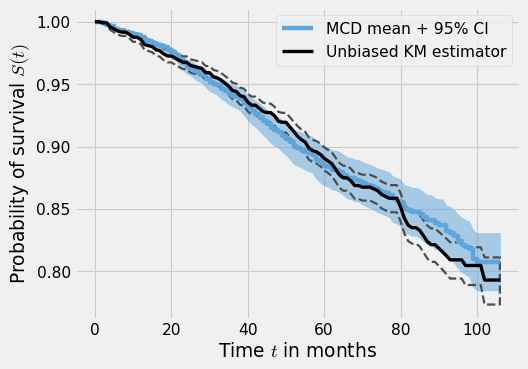

In [16]:
plt.figure(dpi=80)
plt.step(event_times, mcd_mean_surv_times, where="post", label="MCD mean + 95% CI", color=TFColor[3])
plt.plot(km_mean.columns, km_mean.iloc[0], 'k-', label='Unbiased KM estimator', linewidth=3)
plt.fill_between(event_times, mcd_mean_surv_times-mcd_ci_surv, mcd_mean_surv_times+mcd_ci_surv,
                 color=TFColor[3], alpha=0.5)
plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], color="none", edgecolor=TFColor[8], linewidth=2, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ in months")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [17]:
from tools.preprocessor import Preprocessor

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

X_test_g1 = X_test.loc[X_test['Grade'] == "1"]
X_test_g2 = X_test.loc[X_test['Grade'] == "2"]
X_test_g3 = X_test.loc[X_test['Grade'] == "3"]

preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean')
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                                one_hot=True, fill_value=-1)
X_train = np.array(transformer.transform(X_train))
X_test_g1 = np.array(transformer.transform(X_test_g1))
X_test_g2 = np.array(transformer.transform(X_test_g2))
X_test_g3 = np.array(transformer.transform(X_test_g3))

g1_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test_g1, e_train, t_train, MCD_RUNS)
g2_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test_g2, e_train, t_train, MCD_RUNS)
g3_breslow_surv_times = get_breslow_survival_times(mcd_model, X_train, X_test_g3, e_train, t_train, MCD_RUNS)

g1_ci_surv = 1.96 * np.mean(np.std(g1_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
g1_mean_surv_times = np.mean(np.mean(g1_breslow_surv_times, axis=1), axis=0)

g2_ci_surv = 1.96 * np.mean(np.std(g2_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
g2_mean_surv_times = np.mean(np.mean(g2_breslow_surv_times, axis=1), axis=0)

g3_ci_surv = 1.96 * np.mean(np.std(g3_breslow_surv_times, axis=1) / np.sqrt(MCD_RUNS), axis=0) # 95% CI
g3_mean_surv_times = np.mean(np.mean(g3_breslow_surv_times, axis=1), axis=0)

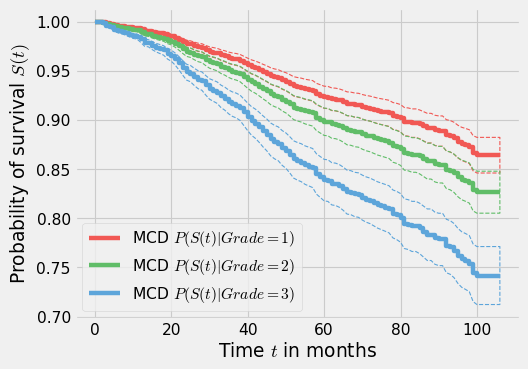

In [18]:
plt.figure(dpi=80)
plt.step(event_times, g1_mean_surv_times, where="post", label="MCD $P(S(t)|Grade=1)$", color=TFColor[0])
plt.step(event_times, g2_mean_surv_times, where="post", label="MCD $P(S(t)|Grade=2)$", color=TFColor[2])
plt.step(event_times, g3_mean_surv_times, where="post", label="MCD $P(S(t)|Grade=3)$", color=TFColor[3])
plt.fill_between(event_times, g1_mean_surv_times-g1_ci_surv, g1_mean_surv_times+g1_ci_surv, color="none", edgecolor=TFColor[0], linewidth=1, ls="--")
plt.fill_between(event_times, g2_mean_surv_times-g2_ci_surv, g2_mean_surv_times+g2_ci_surv, color="none", edgecolor=TFColor[2], linewidth=1, ls="--")
plt.fill_between(event_times, g3_mean_surv_times-g3_ci_surv, g3_mean_surv_times+g3_ci_surv, color="none", edgecolor=TFColor[3], linewidth=1, ls="--")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ in months")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_grade_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [19]:
from tools.model_builder import make_cox_model, make_mlp_model
from utility.survival import compute_survival_times_with_censoring

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

cox_config = load_config(pt.COX_CONFIGS_DIR, f"SEER.yaml")
cox_model = make_cox_model(cox_config)
cox_model.fit(X_train, y_train)
X_test_sample = X_test.iloc[:5]
cox_preds = cox_model.predict(X_test_sample)
cox_st = compute_survival_times(cox_preds, t_train, e_train)

In [20]:
mlp_preds = mlp_model.predict(X_test_sample).flatten()
mlp_st = compute_survival_times(mlp_preds, t_train, e_train)

1/1 [==============================] - 0s 73ms/step


In [21]:
n_samples = 1000
model_cpd_st = np.zeros((n_samples, len(X_test_sample)))
for i in range(0, n_samples):
    pred = np.reshape(mcd_model.predict(X_test_sample, verbose=0), len(X_test_sample))
    model_cpd_st[i,:] = compute_survival_times(pred, t_train, e_train)
st_mean = np.mean(model_cpd_st, axis=0)
st_std = np.std(model_cpd_st, axis=0) 

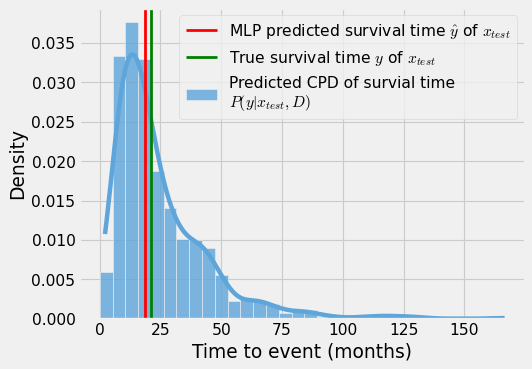

In [24]:
import seaborn as sns
obs_index = 1
HIST_BINS = np.linspace(0, 100, 20)
plt.figure(dpi=80)
sns.histplot(model_cpd_st[:, obs_index], bins=HIST_BINS, color=TFColor[3],
             label="Predicted CPD of survial time \n$P(y|x_{test}, D)$", kde=True, alpha=0.8, stat="density")
plt.axvline(x=mlp_st[obs_index], color='r', linewidth=2.5, label="MLP predicted survival time $\hat{y}$ of $x_{test}$") # TODO: Use y
plt.axvline(x=y_test['time'][obs_index], color='g', linewidth=2.5, label="True survival time $y$ of $x_{test}$") # TODO: Use y
plt.xlabel("Time to event (months)")
plt.legend()
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_pred_cpd_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()